# Projekt Algorytmy Uczenia Maszynowego

## Cel Projektu
Celem tego projektu jest wykorzystanie algorytmów uczenia maszynowego do zrealizowania zadania klasyfikacji.
## Przedstawienie problemu
W ramach projektu zostanie wykonane zadanie klasyfikacji zdjęć zwierząt. Przygotowana implementacja powinna rozpoznawać 
zwierzęta z pięciu różnych klas, w tym przypadku będą to:
* kurczak
* owca
* koń 
* pająk
* słoń

Do realizacji zadania wykorzystano zbiór danych dostępny pod linkiem:
https://www.kaggle.com/datasets/alessiocorrado99/animals10
## Wybrane algorytmy uczenia maszynowego
Jednym z założeń projektowych jest zrealizowanie danego zadnia z wykorzystaniem trzech podstawowych 
algorytmów uczenia maszynowego, w tym przypadku zdecydowano się na wybranie następujących algorytmów:
* Maszyna wektorów nośnych
* Wielowarstwowy perceptron 
* K najbliższych sąsiadów 

Po wykorzystaniu algorytmów uczenia maszynowego należało zaimplementować mechanizm łączenia wykorzystywanych algorytmów.
W tym projekcie zdecydowano się na wykorzystanie `głosowania większościowego`.   

## Wczytanie oraz wizualizacja zbioru danych  
Jednym z kluczowych elementów w zadania klasyfikacji jest dobranie odpowiedniego zbioru danych.
W tym przypadku zaszła potrzeba usunięcia części elementów ze zbioru ze względu na ich jakość.
Zdjęcia w których występowało wiele zwierząt, były bardzo zaszumione albo przedstawiały nie te 
zwierzęta musiały zostać usunięte. W efekcie końcowym zbiory danych zostały zmniejszone do 250 
zdjęć dla każdej klasy. Mimo zmniejszenia zbioru uczącego uzyskano lepsze rezultaty.  


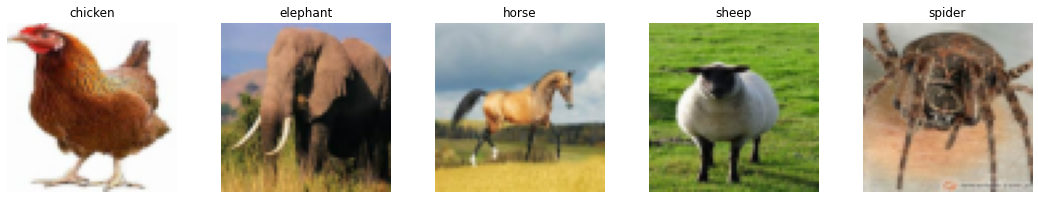

In [1]:
from skimage.io import imread_collection
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
from skimage import exposure
from scipy import ndimage
from skimage import util
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump

def load_images(class_name, values, labels):
    path_to_image = 'raw-img/'
    postfix = '/*.jp*'
    image_size = (64,64,3)
    i = 0
    for image in imread_collection(path_to_image + class_name + postfix):
        
        img = resize(image, image_size)
        values.append(img)
        labels.append(class_name)
        values.append(exposure.adjust_sigmoid(img))
        labels.append(class_name)
        values.append(exposure.adjust_gamma(img))
        labels.append(class_name)
        values.append(ndimage.uniform_filter(img,(2,2,1)))
        labels.append(class_name)
        values.append(rotate(img, -30))
        labels.append(class_name)
        values.append(rotate(img, 30))
        labels.append(class_name)
        values.append(rotate(img, -60))
        labels.append(class_name)
        values.append(util.random_noise(img))
        labels.append(class_name)


def create_data_set():
    class_names = ['spider', 'horse', 'elephant', 'chicken', 'sheep']
    values = []
    labels = []
    for class_name in class_names:
        load_images(class_name, values, labels)

    return np.array(values), np.array(labels)

def plot_data_set(x, y, unique_labels):
    fig, axes = plt.subplots(1, len(unique_labels))
    fig.set_size_inches(15,4)
    fig.tight_layout()

    for ax, label in zip(axes, unique_labels):
        ax.imshow(x[np.where(y == label)[0][0]])
        ax.axis('off')
        ax.set_title(label)

x, y = create_data_set()
unique_labels = np.unique(y)

plot_data_set(x, y, unique_labels)


## Ekstrakcja cech

Niezbędnym elementem w wykorzystaniu algorytmów uczenia maszynowego do zadania klasyfikacji jest wyciągniecie 
najważniejszych informacji ze zbioru uczącego. W przypadku danych jakimi są obrazy można zrobić to na wiele sposobów, 
miedzy innymi:
* wykorzystać histogram
* wykorzystać operatory pozwalające uwypuklić krawędzie
* wykorzystać bardziej skomplikowane algorytmy takie jakie np. transformacja HOGa czy cechy Haar

Do realizacji tego zadania zdecydowano się na wybranie transformaty `HOG`.

### Transformacja HOG(Histogram zorientowanych gradientów)

Opis cech wykorzystujący histogram zorientowanych gradientów, wymaga wykonania wielu pośrednich operacji 
aby uzyskiwać oczekiwane rezultaty. 

##### Wyznaczenie gradientów

Pierwszym krokiem jest wyznaczanie gradientów z w pionie oraz w poziomie wykorzystując filtrując z wykorzystaniem jąder:

$$ [-1, 0, 1] \text{ oraz }  [-1, 0, 1]^T$$

##### Kierunek oraz natężenie gradientów

Kolejnym krokiem jest obliczenie natężenie gradientów oraz ich kierunków zgodnie z wzorami


$$
    g = \sqrt{g^2_x + g^2_y}
$$

$$
    \theta = arctan\frac{g_y}{g_x}
$$

#### Obliczanie histogramów gradientów

Kolejnym elementem było obliczanie gradientów, aby to zrobić obraz należy podzielić na komórki a następnie dla każdej 
z komórek dodać wartości gradientów aby uzyskać histogram dla danej ilości kierunków.

#### Normalizacja gradientów

Ostatnim elementem jest normalizacja gradientów. Normalizacja gradientów polega na dobraniu bloków złożonych z komórek
a następnie wykonania dla niej normalizacji w taki sposób jak dla wektorów.


### Wykorzystanie transformacji HOG

W ramach projektu wykorzystano gotową implementację pozwalającą z biblioteki scikt-image na dostarczenie deskryptorów HOG.
Przy czym najważniejsze parametry jakie zostały wykorzystane to:

* orientation — ilość kierunków gradientów branych pod uwagę
* pixels_per_cell — ilość pikseli w jednej komórce 
* cells_per_block — ilość komórek w jednym bloku

Wyżej wymienione parametry zostały dobrane z wykorzystaniem przeszukania (`GridSearchCV`), tak aby dostarczyć
klasyfikatorom najlepszy zestaw cech.

Aby przedstawić efekt działania transformaty HOG można wykorzystać parameter `visualize`, dzięki któremu można zwrócić
wizualny efekt działania operacji co zostało przedstawione poniżej.


Ostatnim elementem poniższego bloku jest podzielenie zbioru(z wykorzystaniem funkcji `train_test_split`) na część testową
oraz część treningową w proporcji jeden do cztery. Przy podziale wykorzystano parameter `shuffle`, który pozwala na
wstępne przetasowanie danych. Wykorzystano także parametr `random_state`, który pozwala na podział danych 
w powtarzalny sposób.  




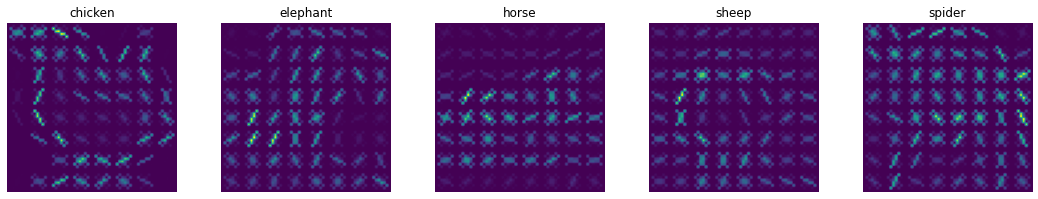

In [2]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.exposure import histogram
from skimage.color import rgb2gray, rgb2hsv



def get_histogram(image, bins, channel):
    hist, _ = histogram(rgb2hsv(image)[:, :, channel], nbins=bins)
    return hist

def get_all_colors_histograms(image, bins = 110):
    return np.reshape((get_histogram(image, bins, 0), get_histogram(image, bins, 1), get_histogram(image, bins, 2)), (bins*3))


def extract_hog_features(values, orientation = 5, pixels_per_cell=(8,8), cells_per_block=(8,8)):
    scalify = StandardScaler()
    return scalify.fit_transform(
        np.array(
            [ np.concatenate(
                    (hog(rgb2gray(img), orientations=orientation, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block), get_all_colors_histograms(img))) for img in values ]))

def plot_hog_features_extraction(x, y, unique_labels, orientation = 4, pixels_per_cell=(8,8), cells_per_block=(8,8)):
    fig, axes = plt.subplots(1, len(unique_labels))
    fig.set_size_inches(15,4)
    fig.tight_layout()

    for ax, label in zip(axes, unique_labels):
        fd, img = hog(
            image=x[np.where(y == label)[0][0]],
            orientations=orientation,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=True,
            channel_axis=-1) 
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

hog_train = extract_hog_features(x)
plot_hog_features_extraction(x, y, unique_labels)

x_train, x_test, y_train, y_test = train_test_split(hog_train, y, test_size=0.2, shuffle=True, random_state=15)

del x

## Wykorzystanie maszyny wektorów nośnych(SVM) w zadaniu klasyfikacji

Algorytm `SVM` można potraktować jako rozwinięcie modelu perceptronu. Wykorzystanie algorytmu perceptronu daje możliwość minimalizowania błędu klasyfikacji, z kolei podstawowym celem SVM jest maksymalizacja marginesu. Przy czym margines jest odległością pomiędzy hiperprzestrzenią rozdzielającą(granicą decyzyjną) a najbliższymi próbkami uczącymi(`wektorami nośnymi`). Wykorzystując algorytm SVM dążymy do uzyskania szerokich granic decyzyjnych, ponieważ takie modele są bardziej odporne na błędy uogólnienia, natomiast możliwie jest wystąpienie przetrenowanie. 

W przypadku algorytmu ważnym parametrem jest  `C`, sterując wartością `C` można kontrolować karę za niewłaściwą klasyfikację. Duże wartości `C` zwiększają kary za błędną klasyfikację, natomiast małe wartości `C` zmniejszają kary. Im większy jest parametr `C` tym bardziej generalizujmy model jednocześnie zmniejszamy margines, małe wartości `C` mogą doprowadzić do przetrenowania modelu. Wartość parametru `C` została dobrana za wykorzystaniem przeszukania GridSearchCV.

Kolejnym istotnym elementem algorytmu `SVM` jest dobranie odpowiedniego jądra. Zadanie klasyfikacji dla danych rozdzielnych z wykorzystaniem liniowej hiperpłaszczyzny jest trywialnym zadaniem z punktu widzenia algorytmu `SVM`. W momencie w którym dane nie są rozdzielne w sposób liniowy sytuacja jest gorsza, jednak zastosowanie odpowiedniej funkcji jądrowej pozwala na utworzenie nieliniowych kombinacji pierwotnych cech, które finalnie mogą być mapowane na przestrzenie o większej liczbie wymiarów, w których to będą liniowo separowalne. Po przeanalizowaniu dostępnych przypadków wybrano funkcje `RBF`(radial basis function).



In [3]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm

svm_svc = svm.SVC(C=2, random_state=15)
svm_svc.fit(x_train, y_train)

test_labels_predicted = svm_svc.predict(x_test)

print('SVM percentage correct for test data: ', 100*accuracy_score(test_labels_predicted, y_test))
print(classification_report(y_test, test_labels_predicted))
print(confusion_matrix(y_test, test_labels_predicted))

dump(svm_svc, 'svm.sav')

SVM percentage correct for test data:  89.61885656970912
              precision    recall  f1-score   support

     chicken       0.91      0.92      0.92       403
    elephant       0.89      0.90      0.90       431
       horse       0.89      0.87      0.88       394
       sheep       0.87      0.85      0.86       360
      spider       0.92      0.93      0.92       406

    accuracy                           0.90      1994
   macro avg       0.90      0.89      0.90      1994
weighted avg       0.90      0.90      0.90      1994

[[372   3  11   9   8]
 [ 11 388  10  17   5]
 [  7  17 344  16  10]
 [  9  17  17 306  11]
 [  9   9   6   5 377]]


['svm.sav']

## Wyniki Algorytmu SVM

Dla zbioru testowego wydajność jest powyżej 80 procent co do daje względnie dużą dokładność. Najgorsze wyniki klasyfikacji zostały otrzymane dla konia natomiast najlepsze dla kurczaka, słonia oraz pająka.
Rozważając macierz pomyłek można zauważyć iż przypadki zarówno fałszywie negatywne jak i fałszywie pozytywne dla są rozłożone między innymi wszystkimi klasami, najmniej pomyłek można zauważyć dla pająka.
Można zauważyć, że kurczak jest najmniej mylony ze słoniem. Najwięcej pomyłek można zauważyć dla konia oraz owcy, jednak i dla tych klas pomyłki rozkładają się równomiernie między pozostałymi klasami.

## Krzywa uczenia algorytmów ucznia maszynowego

Jednym z elementów pomocniczych w trakcie wykorzystywania algorytmów ucznia maszynowego jest krzywa uczenia. 
Przez analizę krzywej uczenia można obserwować, czy model nie został przetrenowany, jak skaluje się model
oraz jakie wyniki uzyskuje. Poniżej zostało zaimplementowane wyświetlanie krzywych ucznie z wykorzystaniem 
walidacji krzyżowej.


In [4]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    X,
    y,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    
    _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title('Learning curves')
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
   
    # Plot learning curvea
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=15)


## Poniżej zostały przedstawione krzywe uczenia dla algorytmu SVM

Obserwując krzywe uczenia

<module 'matplotlib.pyplot' from '/home/wiktor/Desktop/AlgorytmyUczeniaMaszynowego/ml_project/lib/python3.8/site-packages/matplotlib/pyplot.py'>

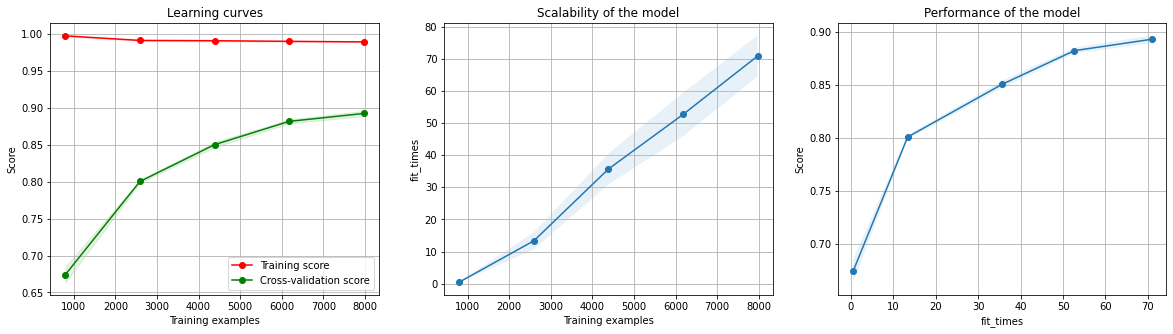

In [5]:
plot_learning_curve(svm_svc, hog_train, y, cv=cv, n_jobs=4)

# Wykorzystanie perceptronu wielowarstwowego(MLP) w zadaniu klasyfikacji

Kolejnym wykorzystanym algorytmem w projekcie jest MLP - `Multi layer perceptron`. Jest to algorytm szeroko wykorzystywany
w uczeniu nadzorowanym do realizacji zadania regresji jak i klasyfikacji. Algorytm opiera się o wykorzystanie warstwy  
wejściowej, wyjściowej oraz warstw ukrytych. Warstwa wejściowa to zbiór cech przekazywanych do algorytmy, warstwa 
wyjściowa to predykcje wytworzone przez model. Warstwy ukryte składają się z perceptronów, które są odpowiedzialne 
za naukę modelu. Działanie warstw ukrytych opiera się w wykorzystanie wielu perceptronów, do każdego z perceptronów
zostaje ważona suma cech, która następnie zostaje poddawana działaniu funkcji aktywacyjne np. funkcji ReLU. 
Funkcja aktywacyjna wykonuje progowanie, biorąc pod uwagę funkcje ReLU daną wzorem:

$$
    f(x) = max(0, x),
$$

dla wartości mniejszych równych od 0 zwraca zero w innym przypadku zwraca daną liczbę.

Algorytm przechodząc od warstwy wejściowej do wyjściowej działa jak algorytm `Feedforward`, finalnie zwracając oczekiwaną
predykcje. Następnie algorytm musi się uczyć, ucznie odbywa się poprzez wsteczną propagację. Wsteczna propagacja jest 
odpowiedzialna za dopasowanie wag dla kolejnych elementów warstw tak aby uzyskać najlepszy efekt uczenia. Wsteczna 
propagacja to zadanie optymalizacji w którym szukane są wagi, takie które minimalizują błąd uczenia.


Do wykonywanego zadani wykorzystano dostępna implementacje algorytmu w bibliotece sklearn.
Wykorzystując ten można manipulować miedzy innymi parametrami:

* activation  - funkcja aktywacyjna 
* solver - algorytm optymalizacji wykorzystywany do propagacji wstecznej.
* alpha - regularyzacja L2 

W tym przypadku jako funkcja aktywacyjna najlepiej sprawdziła się funkcja ReLU, jako algorytm optymalizacji wykorzystano 
`adam`. 

W przypadku `MLP` najbardziej manipulowano parametrem alpha, parametr odpowiada za dodanie funkcji kary, która ogranicza wagi.
Sterowanie tym parametrem umożliwia uniknięcie zjawiska przetrenowania, po przez karanie wag o dużych wartościach.
Domyślnie parametr przyjmuje wartość zero, jednak w tym przypadku taka wartość dawała gorsze rezultaty. w trakcie testów 
sprawdzono, że najlepsze rezultaty są osiągane dla wartości równej jeden.   

 

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

mlp_classifier = MLPClassifier(alpha=1, early_stopping=True,hidden_layer_sizes = (50,), random_state = 15)
mlp_classifier.fit(x_train, y_train)

labels_predicted_mlp = mlp_classifier.predict(x_test)

print('MLP percentage correct: ', 100*accuracy_score(labels_predicted_mlp, y_test))
print(classification_report(y_test, labels_predicted_mlp))
print(confusion_matrix(y_test, labels_predicted_mlp))
dump(mlp_classifier, 'mlp.sav')

MLP percentage correct:  83.1494483450351
              precision    recall  f1-score   support

     chicken       0.88      0.86      0.87       403
    elephant       0.83      0.82      0.82       431
       horse       0.80      0.80      0.80       394
       sheep       0.78      0.80      0.79       360
      spider       0.86      0.88      0.87       406

    accuracy                           0.83      1994
   macro avg       0.83      0.83      0.83      1994
weighted avg       0.83      0.83      0.83      1994

[[346  12  16  15  14]
 [ 13 352  23  29  14]
 [ 11  28 317  25  13]
 [ 13  18  27 287  15]
 [ 10  13  15  12 356]]


['mlp.sav']

## Poniżej zostały przedstawione krzywe uczenia dla algorytmu MLP

<module 'matplotlib.pyplot' from '/home/wiktor/Desktop/AlgorytmyUczeniaMaszynowego/ml_project/lib/python3.8/site-packages/matplotlib/pyplot.py'>

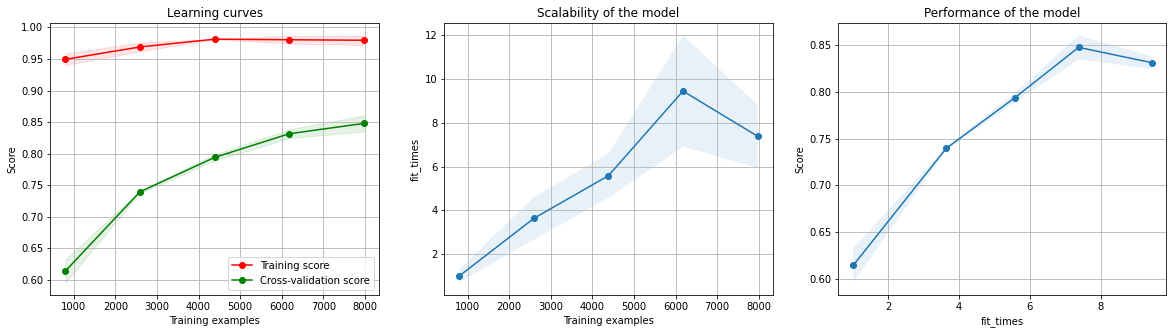

In [7]:
plot_learning_curve(mlp_classifier, hog_train, y, cv=cv, n_jobs=4)

# Wykorzystanie k najbliższych sąsiadów(KNN) w zadaniu klasyfikacji

Algorytm k - najbliższych sąsiadów. Jest innym algorytmem niż poprzednie dwa poprzednie, nie uczy się on funkcji 
dyskryminacyjnej na podstawie danych uczących, lecz stara się zapamiętać cały zbiór próbek.

Algorytm KNN jest dość prosty, działanie algorytmu można przedstawić w trzech krokach:
* wybranie ilości sąsiadów oraz metryki odległości
* znalezienie k najbliższych sąsiadów 
* przydzielenie etykietę klasy poprzez głosowane większościowe

W przypadku tego projektu została została wybrana metryka `Mińkowskiego`, ze współczynnikiem `p = 2`, co w rezultacie
daje metrykę euklidesową. Ilość sąsiadów została dobrana poprzez przeszukanie siatki, liczba wybranych sąsiadów wynosi `k=6`.
 

In [8]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(x_train, y_train)

labels_predicted_neigh = neigh.predict(x_test)
print('Knn percentage correct: ', 100*accuracy_score(labels_predicted_neigh, y_test))
print(classification_report(y_test, labels_predicted_neigh))
print(confusion_matrix(y_test, labels_predicted_neigh))

dump(mlp_classifier, 'knn.sav')


Knn percentage correct:  80.44132397191575
              precision    recall  f1-score   support

     chicken       0.66      0.91      0.77       403
    elephant       0.80      0.84      0.82       431
       horse       0.93      0.73      0.82       394
       sheep       0.83      0.74      0.79       360
      spider       0.88      0.79      0.83       406

    accuracy                           0.80      1994
   macro avg       0.82      0.80      0.81      1994
weighted avg       0.82      0.80      0.81      1994

[[368   5   2  12  16]
 [ 43 361   5  14   8]
 [ 50  34 286  15   9]
 [ 47  28   7 268  10]
 [ 46  21   6  12 321]]


['knn.sav']

## Poniżej zostały przedstawione krzywe uczenia dla algorytmu KNN

<module 'matplotlib.pyplot' from '/home/wiktor/Desktop/AlgorytmyUczeniaMaszynowego/ml_project/lib/python3.8/site-packages/matplotlib/pyplot.py'>

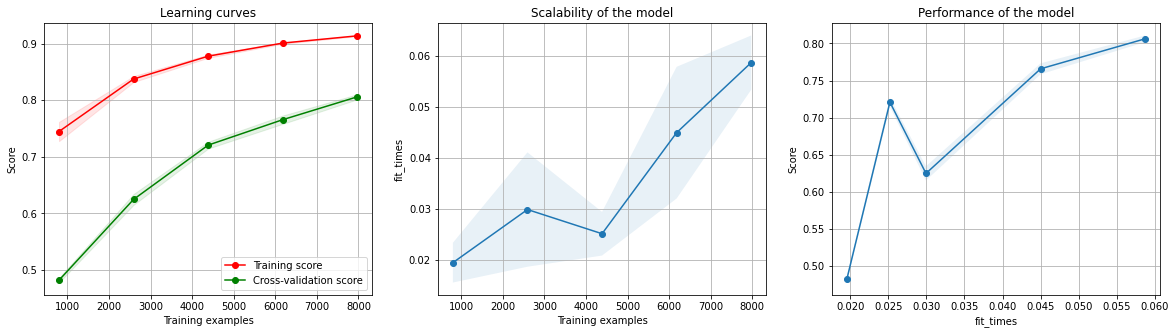

In [9]:
plot_learning_curve(neigh, hog_train, y, cv=cv, n_jobs=4)

## Techniki łączeni algorytmów uczenia maszynowego 

### Głosowanie ze względu na większość głosów 

Kolejnym elementem projektu było zaimplementowanie klasyfikatora umożliwiającego łącznie wcześniej wykorzystywanych
algorytmów uczenia maszynowego. Zdecydowano się na wykorzystanie łączenia algorytmów z wykorzystaniem głosowania 
większościowego. Głosowanie większościowe polega wykorzystaniu dowolnych klasyfikatorów następnie porównaniu ich 
wyników i w efekcie końcowym wybranie najpopularniejszej klasyfikacji. Dodatkowym elementem jest możliwość wykorzystania 
klasyfikatorów z różnymi wagami co mogłoby usprawnić działanie klasyfikatora.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder

class VoteClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, classifiers, weights=None):
        self.classifiers = classifiers
        self.weights = weights
        self.label_encoder = LabelEncoder()

        
    def fit(self, x_train, y_train):
        return self

    def predict(self, x_test):
        result = np.asarray([clf.predict(x_test) for clf in self.classifiers])

        result = self.transform_labels(result)
    
        final_result = np.apply_along_axis(self.get_argmax_class, axis=0, arr = result)

        return self.label_encoder.inverse_transform(final_result)

    def raise_error_when_weights_and_classifiers_have_different_length(self):
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Liczba klasyfikatorów musi być równa liczbie wag dostępne wagi: {len(self.weights)}, klasyfikatory: {len(self.classifiers)}')

    def transform_labels(self, predictions):
        fitted_labels = []
        for i in range(len(self.classifiers)):
            self.label_encoder.fit(predictions[i])
            fitted_labels.append(self.label_encoder.transform(predictions[i]))
        
        return fitted_labels


    def get_argmax_class(self,y_value):
         return np.argmax(np.bincount(y_value, weights=self.weights))

max_target = VoteClassifier([ svm_svc, neigh, mlp_classifier ], [0.7, 0.8, 0.9])

pred = max_target.predict(x_test)
print('SVM, MLP and KNN percentage correct: ', 100*accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))


SVM, MLP and KNN percentage correct:  88.76629889669006
              precision    recall  f1-score   support

     chicken       0.91      0.92      0.92       403
    elephant       0.88      0.89      0.89       431
       horse       0.87      0.85      0.86       394
       sheep       0.86      0.85      0.86       360
      spider       0.91      0.92      0.91       406

    accuracy                           0.89      1994
   macro avg       0.89      0.89      0.89      1994
weighted avg       0.89      0.89      0.89      1994

[[371   6   8   9   9]
 [ 10 385  10  17   9]
 [  7  22 335  19  11]
 [  8  16  20 307   9]
 [ 10   9  10   5 372]]


## Efekty wykorzystania głosowania większościowego
Jak można zauważyć w efekcie końcowym wykorzystanie techniki głosowania większościowego pozwoliło na  delikatnej 
poprawy w klasyfikacji. Manipulując wagami prawdopodobnie można osiągnąć lepszy rezultat klasyfikacji.   